In [1]:
import matplotlib.pyplot as plt
import multipsi as mtp
import numpy as np
import veloxchem as vlx

np.set_printoptions(precision=6, suppress=True, linewidth=170)

mol_str = """
H     0.000000    0.000000   -0.70
H     0.000000    0.000000    0.70
"""
molecule = vlx.Molecule.read_molecule_string(mol_str, units="au")
basis = vlx.MolecularBasis.read(molecule, "cc-pvdz",ostream=None)

norb = basis.get_dimensions_of_basis()

scf_drv = vlx.ScfRestrictedDriver()
scf_drv.ostream.mute()
scf_results = scf_drv.compute(molecule, basis)
hf_energy = scf_drv.get_scf_energy()

In [2]:
molecule.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [3]:
space = mtp.OrbSpace(molecule, scf_drv.mol_orbs)
space.fci()

ci_drv = mtp.CIDriver()
ci_drv.ostream.mute()
ci_results = ci_drv.compute(molecule, basis, space)
ci_energy = ci_results["energies"][0]

In [4]:
print(f"HF energy: {hf_energy : .8f}")
print(f"CI energy: {ci_energy : .8f}")
print(f"Correlation energy: {ci_energy - hf_energy : .8f}")

HF energy: -1.12870945
CI energy: -1.16339873
Correlation energy: -0.03468928


In [5]:
vis_drv = vlx.VisualizationDriver()

In [6]:
def get_orbital_values(coords, molecule, basis, mol_orbs):
    orbital_values = []

    for i in range(norb):
        values = np.array(vis_drv.get_mo(coords, molecule, basis, mol_orbs.alpha_to_numpy(), i))
        orbital_values.append(values)

    return orbital_values

In [7]:
def get_n1(orbital_values):

    hf_onepart_denmat = np.zeros((norb, norb))
    hf_onepart_denmat[0, 0] = 2.0  # first MO is doubly occupied
    fci_onepart_denmat = ci_drv.get_active_density(0)

    # One-particle densities for HF and FCI
    n1_hf = np.zeros(n)
    n1_fci = np.zeros(n)
    
    for i in range(norb):
        for j in range(norb):
            n1_hf += hf_onepart_denmat[i, j] * orbital_values[i] * orbital_values[j]
            n1_fci += fci_onepart_denmat[i, j] * orbital_values[i] * orbital_values[j]

    return n1_hf, n1_fci

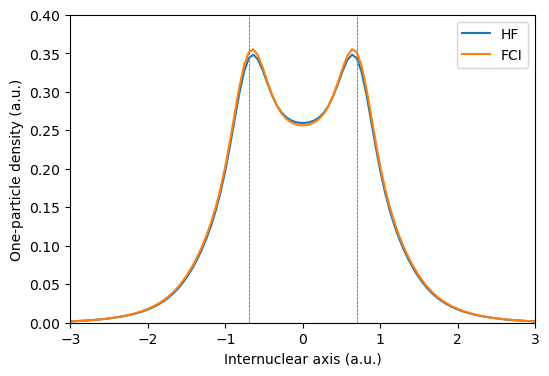

In [8]:
n = 100
coords = np.zeros((n, 3))
coords[:, 2] = np.linspace(-3, 3, n, endpoint=True)

orbital_values = get_orbital_values(coords, molecule, basis, scf_drv.mol_orbs)
n1_hf, n1_fci = get_n1(orbital_values)

plt.figure(figsize=(6,4))
plt.plot(coords[:, 2], n1_hf, label="HF")
plt.plot(coords[:, 2], n1_fci, label="FCI")
plt.legend()

plt.axvline(x=0.70, color="0.5", linewidth=0.7, dashes=[3, 1, 3, 1])
plt.axvline(x=-0.70, color="0.5", linewidth=0.7, dashes=[3, 1, 3, 1])
plt.setp(plt.gca(), xlim=(-3, 3), ylim=(0, 0.40))

plt.ylabel("One-particle density (a.u.)")
plt.xlabel("Internuclear axis (a.u.)")

plt.show()

In [9]:
def get_n12(orbital_values_1, orbital_values_2):

    hf_twopart_denmat = np.zeros((norb,norb,norb,norb))
    hf_twopart_denmat[0,0,0,0] = 2.0 # first MO is doubly occupied
    ci_twopart_denmat = ci_drv.get_active_2body_density(0)
    
    # Two-particle densities for HF and FCI
    n12_hf = np.zeros(n)
    n12_fci = np.zeros(n)

    for i in range(norb):
        for j in range(norb):
            for k in range(norb):
                for l in range(norb):

                    n12_hf += (
                        hf_twopart_denmat[i, j, k, l]
                        * orbital_values_1[i]
                        * orbital_values_1[j]
                        * orbital_values_2[k]
                        * orbital_values_2[l]
                    )

                    n12_fci += (
                        ci_twopart_denmat[i, j, k, l]
                        * orbital_values_1[i]
                        * orbital_values_1[j]
                        * orbital_values_2[k]
                        * orbital_values_2[l]
                    )

    return n12_hf, n12_fci

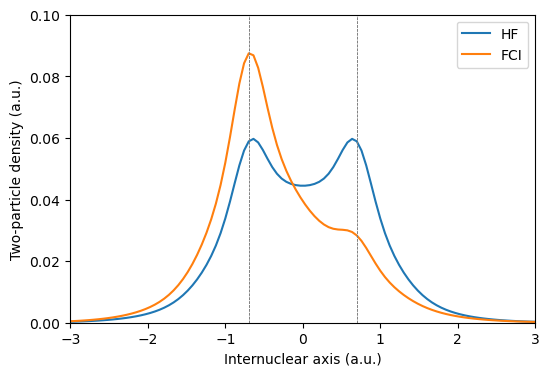

In [10]:
# electron 1 at the position of the hydrogen nucleus
orbital_values_at_H1 = get_orbital_values([[0, 0, 0.70]], molecule, basis, scf_drv.mol_orbs)
n12_hf, n12_fci = get_n12(orbital_values_at_H1, orbital_values)

plt.figure(figsize=(6,4))
plt.plot(coords[:, 2], n12_hf, label="HF")
plt.plot(coords[:, 2], n12_fci, label="FCI")
plt.legend()

plt.axvline(x=0.70, color="0.5", linewidth=0.7, dashes=[3, 1, 3, 1])
plt.axvline(x=-0.70, color="0.5", linewidth=0.7, dashes=[3, 1, 3, 1])
plt.setp(plt.gca(), xlim=(-3, 3), ylim=(0, 0.10))

plt.ylabel("Two-particle density (a.u.)")
plt.xlabel("Internuclear axis (a.u.)")
plt.show()

In [11]:
molecule = vlx.Molecule.read_molecule_string("He  0.0 0.0 0.0")

theta = np.linspace(-np.pi, np.pi, n, endpoint=True)
coords = np.zeros((n, 3))
coords[:, 0] = 0.70 * np.cos(theta)
coords[:, 1] = 0.70 * np.sin(theta)

# one- and two-particle densities for each basis set in lists
n12_fci_l = []

for basis_set in ["sto-3g", "cc-pvdz", "cc-pvtz", "cc-pvqz"]:

    basis = vlx.MolecularBasis.read(molecule, basis_set)
    norb = basis.get_dimensions_of_basis()
    scf_results = scf_drv.compute(molecule, basis)

    space = mtp.OrbSpace(molecule, scf_drv.mol_orbs)
    space.fci()

    ci_drv = mtp.CIDriver()
    ci_results = ci_drv.compute(molecule, basis, space)

    orbital_values_1 = get_orbital_values([[0.70, 0, 0]], molecule, basis, scf_drv.mol_orbs)
    orbital_values_2 = get_orbital_values(coords, molecule, basis, scf_drv.mol_orbs)

    _, n12_fci = get_n12(orbital_values_1, orbital_values_2)

    n12_fci_l.append(n12_fci)

                                                                                                                          
                          Configuration Interaction Driver
                                                                                                                          

               Active space definition:
               ------------------------
               Number of inactive (occupied) orbitals: 0
               Number of active orbitals:              1
               Number of virtual orbitals:             0

               This is a CASSCF wavefunction: CAS(2,1)

               CI expansion:
               -------------
               Number of determinants:      1


                                                                                                                          
               ╭────────────────────────────────────╮
               │          Driver settings           │
               ╰─────────────────────────────────

                                                                                                                          
** Convergence reached in 0 iterations
                                                                                                                          
               Final results
               -------------
                                                                                                                          
* State 1
  - S^2    : 0.00  (multiplicity = 1.0 )
  - Energy : -2.8077839566141964
  - Natural orbitals
2.00000


                                                                                                                          
                          Configuration Interaction Driver
                                                                                                                          

               Active space definition:
               ------------------------
               Number of inactive (occupied) orbitals: 0
               Number of active orbitals:              5
               Number of virtual orbitals:             0

               This is a CASSCF wavefunction: CAS(2,5)

               CI expansion:
               -------------
               Number of determinants:      25


                                                                                                                          
               ╭────────────────────────────────────╮
               │          Driver settings           │
               ╰────────────────────────────────

                                                                                                                          
** Convergence reached in 0 iterations
                                                                                                                          
               Final results
               -------------
                                                                                                                          
* State 1
  - S^2    : 0.00  (multiplicity = 1.0 )
  - Energy : -2.8875948310909374
  - Natural orbitals
1.98549 0.00832 0.00206 0.00206 0.00206


                                                                                                                          
                          Configuration Interaction Driver
                                                                                                                          

               Active space definition:
               ------------------------
               Number of inactive (occupied) orbitals: 0
               Number of active orbitals:              14
               Number of virtual orbitals:             0

               This is a CASSCF wavefunction: CAS(2,14)

               CI expansion:
               -------------
               Number of determinants:      196


                                                                                                                          
               ╭────────────────────────────────────╮
               │          Driver settings           │
               ╰─────────────────────────────

                                                                                                                          
** Convergence reached in 0 iterations
                                                                                                                          
               Final results
               -------------
                                                                                                                          
* State 1
  - S^2    : -0.00  (multiplicity = 1.0 )
  - Energy : -2.900232169008986
  - Natural orbitals
1.98432 0.00749 0.00252 0.00252 0.00252 0.00016 0.00005 0.00005 0.00005 0.00005 0.00005 0.00007 0.00007 0.00007


                                                                                                                          
                          Configuration Interaction Driver
                                                                                                                          

               Active space definition:
               ------------------------
               Number of inactive (occupied) orbitals: 0
               Number of active orbitals:              30
               Number of virtual orbitals:             0

               This is a CASSCF wavefunction: CAS(2,30)

               CI expansion:
               -------------
               Number of determinants:      900


                                                                                                                          
               ╭────────────────────────────────────╮
               │          Driver settings           │
               ╰─────────────────────────────

                                                                                                                          
                          CI Iterations
                         ----------------
                                                                                                                          
     Iter. | Average Energy | E. Change | Grad. Norm | Subs. size | Time
     ----------------------------------------------------------------------


        1     -2.896709809     1.8e-15      1.4e-01           1    0:00:00


        2     -2.902366010    -5.7e-03      1.9e-04           2    0:00:00


        3     -2.902408620    -4.3e-05      1.5e-05           3    0:00:00


        4     -2.902410779    -2.2e-06      5.4e-07           4    0:00:00


        5     -2.902410876    -9.7e-08      9.1e-09           5    0:00:00


        6     -2.902410878    -2.3e-09      2.6e-10           6    0:00:00


                                                                                                                          
** Convergence reached in 6 iterations
                                                                                                                          
               Final results
               -------------
                                                                                                                          
* State 1
  - S^2    : 0.00  (multiplicity = 1.0 )
  - Energy : -2.9024108779145954
  - Natural orbitals
1.98394 0.00763 0.00256 0.00256 0.00256 0.00012 0.00006 0.00006 0.00006 0.00006 0.00006 0.00008 0.00008 0.00008 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00001 0.00000 0.00000 0.00000 0.00000 0.00000 0.00001 0.00001 0.00001


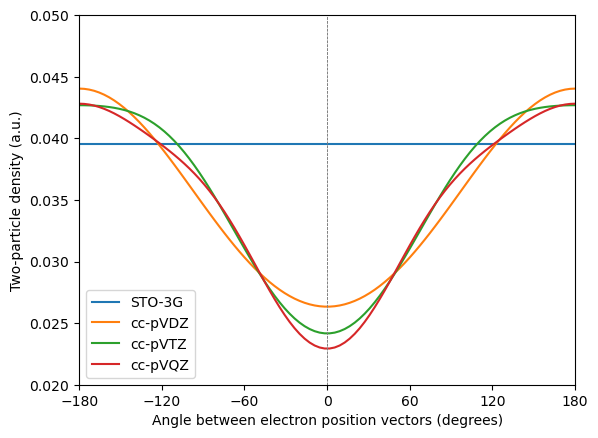

In [12]:
plt.plot(theta * 180 / np.pi, n12_fci_l[0], label="STO-3G")
plt.plot(theta * 180 / np.pi, n12_fci_l[1], label="cc-pVDZ")
plt.plot(theta * 180 / np.pi, n12_fci_l[2], label="cc-pVTZ")
plt.plot(theta * 180 / np.pi, n12_fci_l[3], label="cc-pVQZ")
plt.legend()

plt.axvline(x=0, color="0.5", linewidth=0.7, dashes=[3, 1, 3, 1])
plt.setp(plt.gca(), xlim=(-180, 180), ylim=(0.02, 0.05), xticks=range(-180, 190, 60))

plt.ylabel("Two-particle density (a.u.)")
plt.xlabel("Angle between electron position vectors (degrees)")

plt.show()